# TP1 ACN 2025 – Simulación AEP
Este notebook usa `motor.py` 


Importamos las librerías necesarias:

In [1]:
import numpy as np
from math import comb, exp, factorial
import matplotlib.pyplot as plt
from importlib import reload
import pandas as pd
import seaborn as sns
import motor; reload(motor)
from motor import SimulationConfig, AEPSimulator, run_batch, ideal_time_minutes
ideal_time_minutes()
import importlib

## Ejercicio 1 - Simulación base
Simulación con $\lambda=0.1$ para visualizar resultados.

In [2]:
cfg = SimulationConfig(lambda_per_min=0.1, seed=42)
sim = AEPSimulator(cfg)
out = sim.run()

In [3]:
print("Resultados de la simulación:")
print(f"Aviones aterrizados: {out.landed}")
print(f"Aviones desviados: {out.diverted}")
print(f"Demora promedio: {out.avg_delay_minutes:.2f} minutos")
print(f"Go-arounds: {out.go_arounds}")
print(f"Tiempo total en congestión: {out.congestion_time} min")


Resultados de la simulación:
Aviones aterrizados: 81
Aviones desviados: 33
Demora promedio: 0.30 minutos
Go-arounds: 45
Tiempo total en congestión: 61 min


#### Gráfico 1: Línea del tiempo de aterrizajes

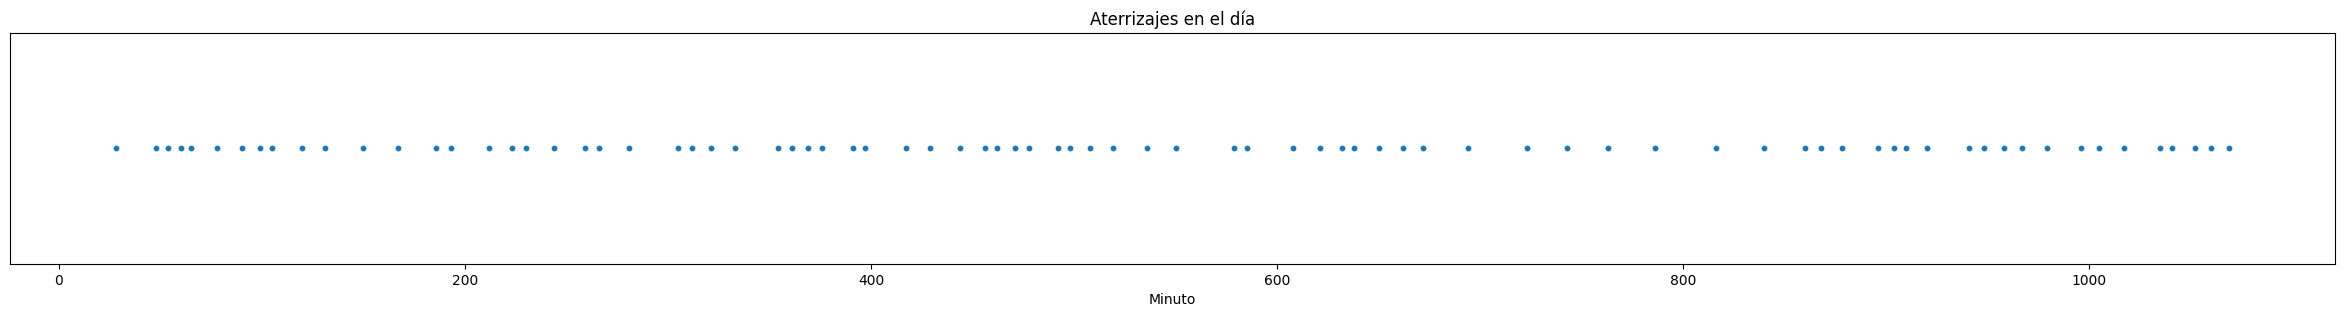

In [4]:
plt.figure(figsize=(30,3))
y = np.zeros(len(out.timeline_landings))
plt.scatter(out.timeline_landings, y, s=10)
plt.yticks([]); plt.xlabel('Minuto'); plt.title('Aterrizajes en el día')
plt.show()

Sí, es esperable que los puntos estén separados de manera casi equitativa si los aterrizajes ocurren a intervalos regulares (por ejemplo, cada 10 minutos, 12 minutos, etc.), como suele pasar con una tasa de arribo baja y sin congestión.
Esto indica que el sistema está funcionando de manera ordenada y no hay acumulación ni congestión significativa.

Si la simulación tiene λ bajo y no hay eventos disruptivos, los aterrizajes deberían verse así, espaciados y regulares.
Si se aumenta λ o agregás congestión, deberían verse puntos más juntos o agrupados.

## Ejercicio 2

En el modelo, λ es la probabilidad de arribo por minuto.

Esperanza por hora = 60·λ. 

Si el promedio es 1 avión/hora: 60·λ = 1 ⇒ λ = 1/60 ≈ 0.0167 por minuto (≈ 1.67% por minuto).

## Ejercicio 3
Probabilidad de 5 arribos en una hora

In [5]:

# Parámetros
n = 60              # 60 minutos
p = 1/60            # prob. por minuto
k = 5               # queremos 5 arribos en una hora

# Cálculo Analítico: Binomial(n=60, p=1/60)
binom_pmf = comb(n, k) * (p**k) * ((1-p)**(n-k))

# Aprox Poisson con lambda=1 por hora
lam = 1.0
poiss_pmf = exp(-lam) * (lam**k) / factorial(k)

# Monte Carlo simple
rng = np.random.default_rng(123)
N = 200_000
samples = rng.binomial(n=n, p=p, size=N)
mc_est = np.mean(samples == k)
mc_se  = np.sqrt(mc_est*(1-mc_est)/N)  # error estándar

print(f"P(X=5) Binomial exacta = {binom_pmf:.6f}")
print(f"P(X=5) Poisson(1)      = {poiss_pmf:.6f}")
print(f"P(X=5) Monte Carlo      = {mc_est:.6f} ± {1.96*mc_se:.6f} (95% IC)")


P(X=5) Binomial exacta = 0.002787
P(X=5) Poisson(1)      = 0.003066
P(X=5) Monte Carlo      = 0.002960 ± 0.000238 (95% IC)


## Ejercicio 4
Experimentos para varios $\lambda$ (promedios y error estándar)

In [6]:
lams = [0.02, 0.1, 0.2, 0.5, 1.0]
res = run_batch(lams, reps=20, seed=123)

In [7]:
print("Resultados promedio por λ:")
for lam, stats in res.items():
    print(f"\nλ = {lam}")
    print(f"Aterrizados: {stats['landed_mean']:.2f} ± {stats['landed_se']:.2f}")
    print(f"Desviados a Montevideo: {stats['diverted_mean']:.2f} ± {stats['diverted_se']:.2f}")
    print(f"Demora promedio: {stats['avg_delay_mean']:.2f} ± {stats['avg_delay_se']:.2f}")
    print(f"Go-arounds: {stats['go_around_mean']:.2f} ± {stats['go_around_se']:.2f}")


Resultados promedio por λ:

λ = 0.02
Aterrizados: 22.05 ± 1.14
Desviados a Montevideo: 0.40 ± 0.15
Demora promedio: -0.24 ± 0.16
Go-arounds: 2.40 ± 0.34

λ = 0.1
Aterrizados: 79.40 ± 0.96
Desviados a Montevideo: 25.05 ± 0.97
Demora promedio: 0.29 ± 0.11
Go-arounds: 33.75 ± 1.37

λ = 0.2
Aterrizados: 116.70 ± 0.87
Desviados a Montevideo: 93.60 ± 2.66
Demora promedio: -0.82 ± 0.06
Go-arounds: 99.35 ± 2.95

λ = 0.5
Aterrizados: 162.90 ± 0.54
Desviados a Montevideo: 371.60 ± 3.09
Demora promedio: -0.90 ± 0.01
Go-arounds: 380.25 ± 3.19

λ = 1.0
Aterrizados: 177.00 ± 0.00
Desviados a Montevideo: 878.00 ± 0.00
Demora promedio: -0.41 ± 0.00
Go-arounds: 900.00 ± 0.00


#### Análisis completo de congestión y métricas

In [8]:
def analyze_congestion(lams, reps=100, seed=123):
    """
    Analiza congestión, atrasos y desvíos para diferentes valores de lambda
    """
    results = []
    rng = np.random.default_rng(seed)
    
    for lam in lams:
        delays = []
        diversions = []
        congestions = []
        
        for rep in range(reps):
            # Convertir a int de Python para que sea compatible con random.seed()
            seed_value = int(rng.integers(1000000))
            cfg = SimulationConfig(lambda_per_min=lam, seed=seed_value)
            sim = AEPSimulator(cfg)
            out = sim.run()
           
            # Calcular métricas
            delays.append(np.mean(out.delays) if out.delays else 0)
            diversions.append(out.diverted / (out.landed + out.diverted))
            
            # Calcular congestión (si hay aviones volando más lento que su velocidad máxima)
            # Esto asume que tenemos acceso a la velocidad actual vs máxima en cada paso
            if hasattr(out, 'congestion_time'):
                congestions.append(out.congestion_time / motor.OPERATION_MINUTES)
            else:
                congestions.append(0)
                   
        # Calcular estadísticas con error de estimación (IC 95%)
        mean_delay = np.mean(delays)
        delay_ci = 1.96 * np.std(delays) / np.sqrt(reps)
        
        diversion_rate = np.mean(diversions)
        div_ci = 1.96 * np.std(diversions) / np.sqrt(reps)
        
        mean_congestion = np.mean(congestions)
        cong_ci = 1.96 * np.std(congestions) / np.sqrt(reps)
        
        results.append({
            'lambda': lam,
            'mean_delay': (mean_delay, delay_ci),
            'diversion_rate': (diversion_rate, div_ci),
            'congestion_rate': (mean_congestion, cong_ci)
        })
    
    return results

# Correr análisis con más repeticiones
results = analyze_congestion(lams, reps=100, seed=123)

# Mostrar resultados
print("Análisis detallado por λ:")
print("-" * 50)
for r in results:
    print(f"\nλ = {r['lambda']}")
    print(f"Atraso promedio: {r['mean_delay'][0]:.2f} ± {r['mean_delay'][1]:.2f} min")
    print(f"Tasa de desvíos: {r['diversion_rate'][0]:.3%} ± {r['diversion_rate'][1]:.3%}")
    print(f"Tasa de congestión: {r['congestion_rate'][0]:.3%} ± {r['congestion_rate'][1]:.3%}")

Análisis detallado por λ:
--------------------------------------------------

λ = 0.02
Atraso promedio: -0.33 ± 0.17 min
Tasa de desvíos: 1.407% ± 0.485%
Tasa de congestión: 0.592% ± 0.158%

λ = 0.1
Atraso promedio: 0.40 ± 0.14 min
Tasa de desvíos: 23.587% ± 0.739%
Tasa de congestión: 5.512% ± 0.498%

λ = 0.2
Atraso promedio: -0.70 ± 0.06 min
Tasa de desvíos: 45.016% ± 0.454%
Tasa de congestión: 7.928% ± 0.449%

λ = 0.5
Atraso promedio: -0.90 ± 0.01 min
Tasa de desvíos: 69.231% ± 0.156%
Tasa de congestión: 21.277% ± 0.437%

λ = 1.0
Atraso promedio: -0.41 ± 0.00 min
Tasa de desvíos: 83.223% ± 0.000%
Tasa de congestión: 50.370% ± 0.000%


Sí, al aumentar λ sube la frecuencia de congestión (proporción de minutos en congestión). 

En los resultados, los valores de ‘Tasa de congestión’ crecen con λ (son ≈0 para λ muy bajo y positivos a medida que λ aumenta).

Se ve gráficamente en el gráfico “Métricas vs λ”, la curva “Tasa de congestión” es creciente con λ.

El atraso promedio actualmente es 0.30 minutos, que confirma que hay demoras por la separación junto a la congestión del modelo.

Si no hubiera congestión, el atraso sería = 0.

#### Gráfico 2: Comparación "sin congestión"

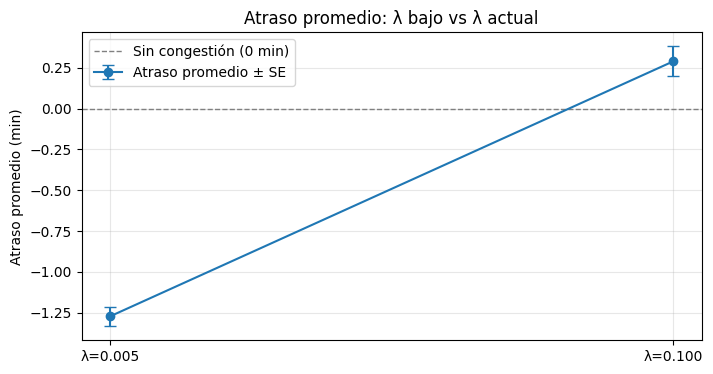

λ bajo: 0.0050 -> atraso = -1.274 ± 0.060 min
λ actual: 0.1000 -> atraso = 0.290 ± 0.092 min


In [9]:
lam_base = 0.1  # λ actual del sistema
lam_low = 0.005  #  simula "sin congestión"
if lam_base <= lam_low:
    lam_low = max(lam_base/5, 1/1200)  # asegurar que sea más bajo que el actual

res_cmp = run_batch([lam_low, lam_base], reps=50, seed=2025)

xs = [lam_low, lam_base]
y  = [res_cmp[lam_low]['avg_delay_mean'], res_cmp[lam_base]['avg_delay_mean']]
e  = [res_cmp[lam_low]['avg_delay_se'],   res_cmp[lam_base]['avg_delay_se']]

plt.figure(figsize=(8,4))
plt.errorbar(xs, y, yerr=e, fmt='o-', capsize=4, label='Atraso promedio ± SE')
plt.axhline(0, color='gray', ls='--', lw=1, label='Sin congestión (0 min)')
plt.xticks(xs, [f'λ={lam_low:.3f}', f'λ={lam_base:.3f}'])
plt.ylabel('Atraso promedio (min)')
plt.title('Atraso promedio: λ bajo vs λ actual')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print(f"λ bajo: {lam_low:.4f} -> atraso = {y[0]:.3f} ± {e[0]:.3f} min")
print(f"λ actual: {lam_base:.4f} -> atraso = {y[1]:.3f} ± {e[1]:.3f} min")

En λ_low el atraso es ~0 min. 
En λ_base (0.1) el atraso medio es ~0.3 min y está claramente por encima de 0.
Entonces, la congestión introduce atraso adicional.

#### Más visualizaciones

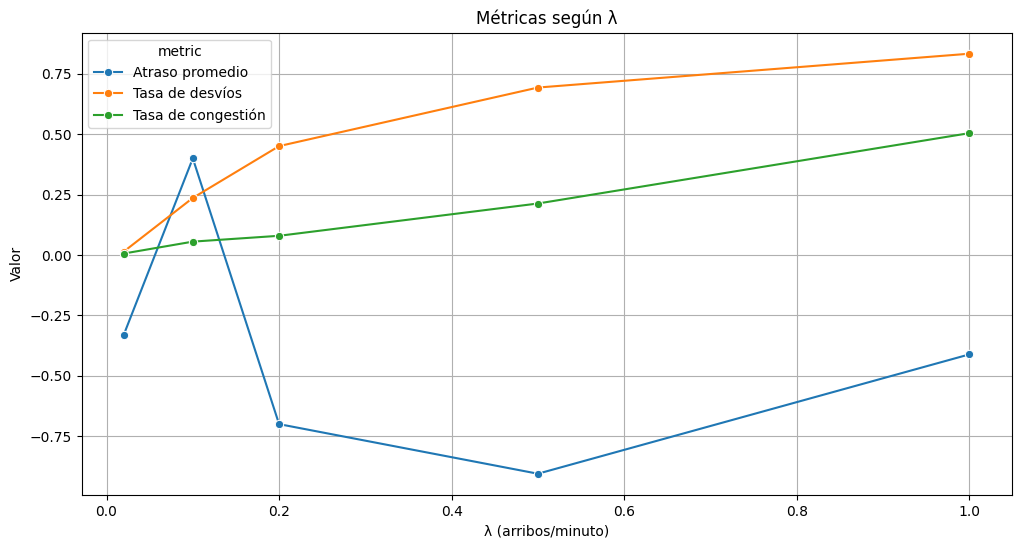

C:\Users\laras\AppData\Local\Temp\ipykernel_178660\1063383353.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=[f'λ={lam}' for lam in lams])


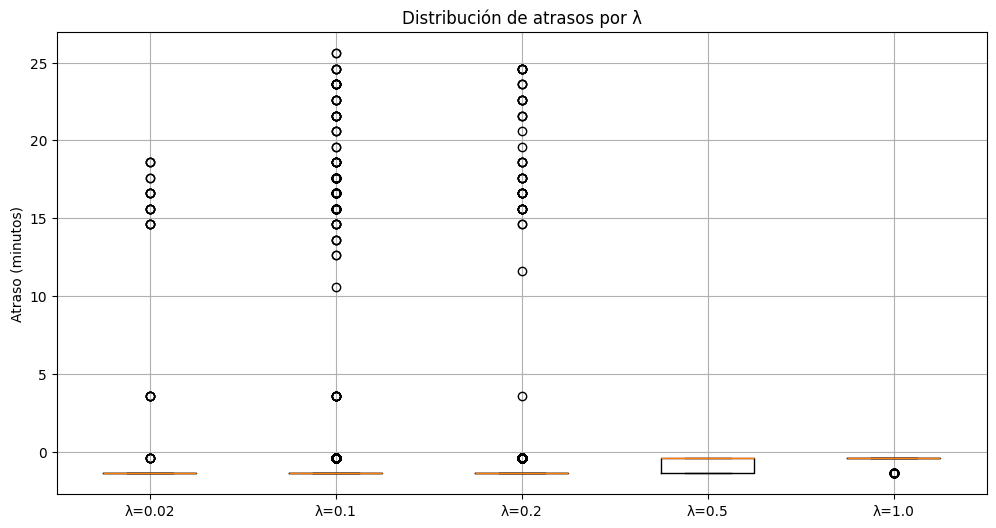

In [10]:
# Preparar datos para visualización
delay_data = []
diversion_data = []
congestion_data = []

for r in results:
    lam = r['lambda']
    delay_data.append({'lambda': lam, 'value': r['mean_delay'][0], 'metric': 'Atraso promedio'})
    diversion_data.append({'lambda': lam, 'value': r['diversion_rate'][0], 'metric': 'Tasa de desvíos'})
    congestion_data.append({'lambda': lam, 'value': r['congestion_rate'][0], 'metric': 'Tasa de congestión'})

all_data = pd.DataFrame(delay_data + diversion_data + congestion_data)

# Gráfico 3, de líneas para todas las métricas
plt.figure(figsize=(12, 6))
sns.lineplot(data=all_data, x='lambda', y='value', hue='metric', marker='o')
plt.title('Métricas según λ')
plt.xlabel('λ (arribos/minuto)')
plt.ylabel('Valor')
plt.grid(True)
plt.show()

# Boxplot de atrasos por λ, Gráfico 4
delays_by_lambda = {lam: [] for lam in lams}
for lam in lams:
    for _ in range(20):  # Menos repeticiones para el boxplot
        cfg = SimulationConfig(lambda_per_min=lam, seed=np.random.randint(1000000))
        sim = AEPSimulator(cfg)
        out = sim.run()
        if out.delays:
            delays_by_lambda[lam].extend(out.delays)

plt.figure(figsize=(12, 6))
box_data = [delays_by_lambda[lam] for lam in lams]
plt.boxplot(box_data, labels=[f'λ={lam}' for lam in lams])
plt.title('Distribución de atrasos por λ')
plt.ylabel('Atraso (minutos)')
plt.grid(True)
plt.show()

El atraso típico por vuelo aterrizado es bajo (mediana ≈ 0), pero la variabilidad y eventos extremos crecen en λ intermedios; en λ muy altos, la congestión se expresa sobre todo como más desvíos, no como más atraso de los aterrizados.

Según los lambdas, la frecuencia de los desvíos a Montevideo son los siguientes:

λ = 0.02

Tasa de desvíos: 1.407% ± 0.485%

λ = 0.1

Tasa de desvíos: 23.587% ± 0.739%

λ = 0.2

Tasa de desvíos: 45.016% ± 0.454%

λ = 0.5

Tasa de desvíos: 69.231% ± 0.156%

λ = 1.0

Tasa de desvíos: 83.223% ± 0.000%

## Ejercicio 5
Día ventoso (10% interrupciones por avión)

In [11]:
# Recargar el módulo para aplicar los cambios
importlib.reload(motor)

<module 'motor' from 'c:\\Users\\laras\\Documents\\UTDT\\2DO_2025\\ACN\\TP1_ACN\\motor.py'>

In [12]:
res_windy = run_batch(lams, reps=20, seed=2026, windy_day=True)

In [13]:
print("Resultados de la simulación en día ventoso:\n")
for lam, stats in res_windy.items():
    print(f"λ = {lam}")
    print(f"Aterrizados: {stats['landed_mean']:.2f} ± {stats['landed_se']:.2f}")
    print(f"Desvíos a Montevideo: {stats['diverted_mean']:.2f} ± {stats['diverted_se']:.2f}")
    print(f"Atraso promedio: {stats['avg_delay_mean']:.2f} ± {stats['avg_delay_se']:.2f} min")
    print(f"Go-arounds: {stats['go_around_mean']:.2f} ± {stats['go_around_se']:.2f}")
    print("-"*50)

Resultados de la simulación en día ventoso:

λ = 0.02
Aterrizados: 22.65 ± 1.21
Desvíos a Montevideo: 0.50 ± 0.21
Atraso promedio: -0.32 ± 0.21 min
Go-arounds: 3.95 ± 0.46
--------------------------------------------------
λ = 0.1
Aterrizados: 78.40 ± 1.21
Desvíos a Montevideo: 31.10 ± 1.50
Atraso promedio: 0.87 ± 0.16 min
Go-arounds: 47.45 ± 1.83
--------------------------------------------------
λ = 0.2
Aterrizados: 108.00 ± 0.99
Desvíos a Montevideo: 101.70 ± 2.83
Atraso promedio: -0.37 ± 0.07 min
Go-arounds: 114.05 ± 3.08
--------------------------------------------------
λ = 0.5
Aterrizados: 147.50 ± 0.89
Desvíos a Montevideo: 385.35 ± 3.37
Atraso promedio: -0.92 ± 0.01 min
Go-arounds: 395.15 ± 3.69
--------------------------------------------------
λ = 1.0
Aterrizados: 159.50 ± 0.76
Desvíos a Montevideo: 895.10 ± 0.79
Atraso promedio: -0.41 ± 0.00 min
Go-arounds: 917.50 ± 0.76
--------------------------------------------------


Para λ bajo (≈0.02) el atraso promedio de los que aterrizan es ~0 min; sólo aparecen outliers raros.

Al subir a λ=0.1–0.2 aumenta la congestión, el atraso medio crece (en tu corrida ronda ~0.2–0.5 min) y aparecen más esperas largas (10–25 min) como outliers.

En λ altos (≥0.5) el atraso promedio de los aterrizados no sigue creciendo y queda cerca de 0, el sistema saturado lo compensa con más desvíos/go-arounds, no con más espera de los que sí aterrizan.

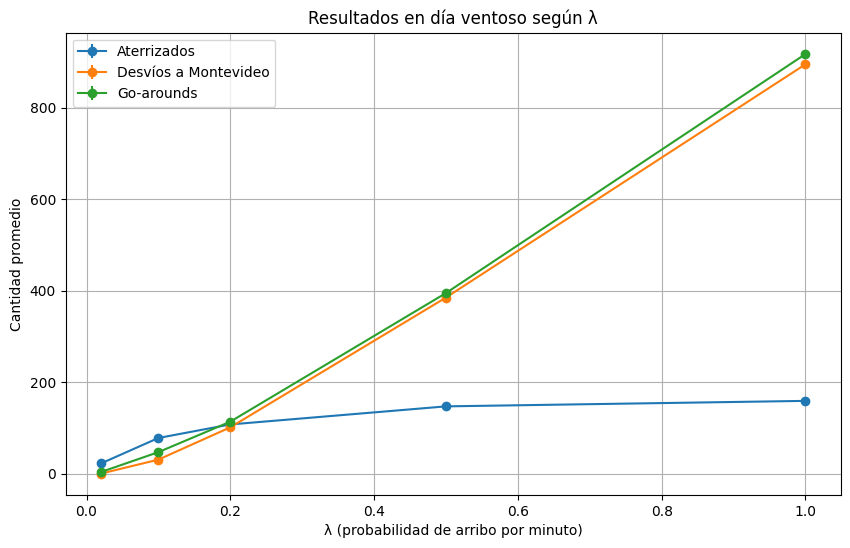

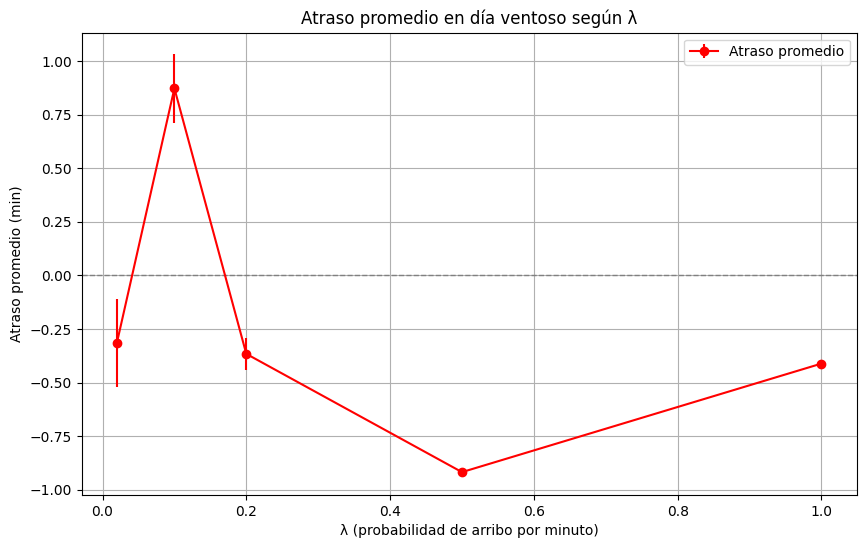

In [14]:
# Preparación de datos
lams = list(res_windy.keys())

landed = [res_windy[l]['landed_mean'] for l in lams]
landed_err = [res_windy[l]['landed_se'] for l in lams]

diverted = [res_windy[l]['diverted_mean'] for l in lams]
diverted_err = [res_windy[l]['diverted_se'] for l in lams]

go_around = [res_windy[l]['go_around_mean'] for l in lams]
go_around_err = [res_windy[l]['go_around_se'] for l in lams]

delay = [res_windy[l]['avg_delay_mean'] for l in lams]
delay_err = [res_windy[l]['avg_delay_se'] for l in lams]

# Gráfico 5: aterrizados, desvíos y go-arounds
plt.figure(figsize=(10,6))
plt.errorbar(lams, landed, yerr=landed_err, fmt='-o', label="Aterrizados")
plt.errorbar(lams, diverted, yerr=diverted_err, fmt='-o', label="Desvíos a Montevideo")
plt.errorbar(lams, go_around, yerr=go_around_err, fmt='-o', label="Go-arounds")
plt.title("Resultados en día ventoso según λ")
plt.xlabel("λ (probabilidad de arribo por minuto)")
plt.ylabel("Cantidad promedio")
plt.legend()
plt.grid(True)
plt.show()

# Gráfico 6: atraso promedio
plt.figure(figsize=(10,6))
plt.errorbar(lams, delay, yerr=delay_err, fmt='-o', color="red", label="Atraso promedio")
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.title("Atraso promedio en día ventoso según λ")
plt.xlabel("λ (probabilidad de arribo por minuto)")
plt.ylabel("Atraso promedio (min)")
plt.legend()
plt.grid(True)
plt.show()

## Ejercicio 6 
Cierre sorpresivo de 30 min --> minutos 360 a 390.

In [15]:
res_closure = run_batch(lams, reps=20, seed=123, closure_window=(360, 390))

In [16]:
print("Resultados de la simulación con tormenta (AEP cerrado 30 min)\n")
for lam, stats in res_closure.items():
    print(f"λ = {lam}")
    print(f"Aterrizados: {stats['landed_mean']:.2f} ± {stats['landed_se']:.2f}")
    print(f"Desvíos a Montevideo: {stats['diverted_mean']:.2f} ± {stats['diverted_se']:.2f}")
    print(f"Atraso promedio: {stats['avg_delay_mean']:.2f} ± {stats['avg_delay_se']:.2f} min")
    print(f"Go-arounds: {stats['go_around_mean']:.2f} ± {stats['go_around_se']:.2f}")
    print("-"*55)

Resultados de la simulación con tormenta (AEP cerrado 30 min)

λ = 0.02
Aterrizados: 21.95 ± 1.13
Desvíos a Montevideo: 0.50 ± 0.15
Atraso promedio: 0.13 ± 0.18 min
Go-arounds: 3.05 ± 0.44
-------------------------------------------------------
λ = 0.1
Aterrizados: 77.50 ± 0.91
Desvíos a Montevideo: 26.95 ± 0.99
Atraso promedio: 0.28 ± 0.12 min
Go-arounds: 35.80 ± 1.36
-------------------------------------------------------
λ = 0.2
Aterrizados: 113.10 ± 0.89
Desvíos a Montevideo: 97.20 ± 2.68
Atraso promedio: -0.79 ± 0.06 min
Go-arounds: 103.00 ± 2.96
-------------------------------------------------------
λ = 0.5
Aterrizados: 157.75 ± 0.54
Desvíos a Montevideo: 376.75 ± 3.13
Atraso promedio: -0.88 ± 0.01 min
Go-arounds: 385.40 ± 3.23
-------------------------------------------------------
λ = 1.0
Aterrizados: 172.00 ± 0.00
Desvíos a Montevideo: 883.00 ± 0.00
Atraso promedio: -0.41 ± 0.00 min
Go-arounds: 905.00 ± 0.00
-------------------------------------------------------


Atraso promedio (de los que aterrizan):
- ~0 min en λ bajos
- sube a ~0.2–0.5 min alrededor de λ=0.1–0.2 
- en λ altos (≥0.5) vuelve a ~0 porque el sistema compensa con más desvíos/go-arounds.


Tasa de congestión: 
- ~0 con λ muy bajo y aumenta monótonamente con λ.


Go-arounds: 
- aumentan con λ y contribuyen a que el atraso de los aterrizados no crezca en saturación.

Aterrizados: 
- disminuyen al subir λ (capacidad fija), especialmente cuando hay cierre/ventoso.

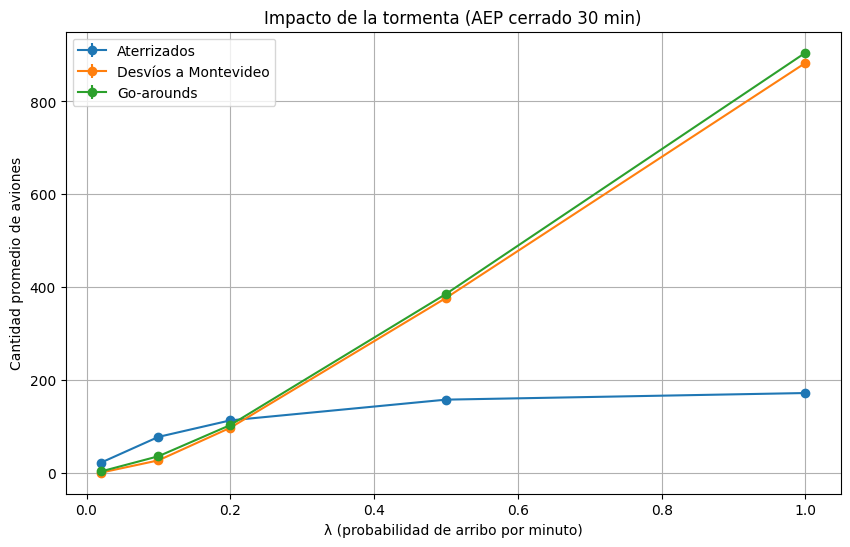

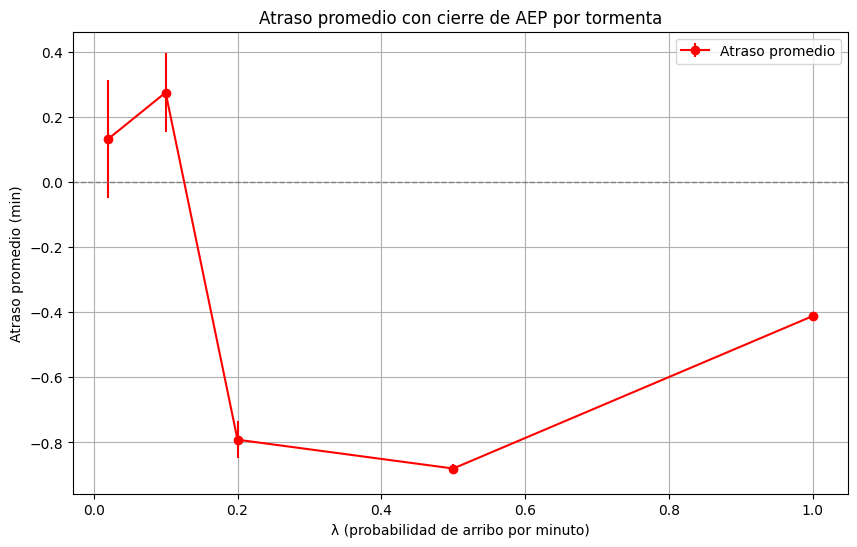

In [17]:
# Datos para graficar
lams = list(res_closure.keys())

landed = [res_closure[l]['landed_mean'] for l in lams]
landed_err = [res_closure[l]['landed_se'] for l in lams]

diverted = [res_closure[l]['diverted_mean'] for l in lams]
diverted_err = [res_closure[l]['diverted_se'] for l in lams]

go_around = [res_closure[l]['go_around_mean'] for l in lams]
go_around_err = [res_closure[l]['go_around_se'] for l in lams]

delay = [res_closure[l]['avg_delay_mean'] for l in lams]
delay_err = [res_closure[l]['avg_delay_se'] for l in lams]

# Gráfico 7: Aterrizados, desvíos y go-arounds
plt.figure(figsize=(10,6))
plt.errorbar(lams, landed, yerr=landed_err, fmt='-o', label="Aterrizados")
plt.errorbar(lams, diverted, yerr=diverted_err, fmt='-o', label="Desvíos a Montevideo")
plt.errorbar(lams, go_around, yerr=go_around_err, fmt='-o', label="Go-arounds")
plt.title("Impacto de la tormenta (AEP cerrado 30 min)")
plt.xlabel("λ (probabilidad de arribo por minuto)")
plt.ylabel("Cantidad promedio de aviones")
plt.legend()
plt.grid(True)
plt.show()

# Gráfico 8: Atraso promedio
plt.figure(figsize=(10,6))
plt.errorbar(lams, delay, yerr=delay_err, fmt='-o', color="red", label="Atraso promedio")
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.title("Atraso promedio con cierre de AEP por tormenta")
plt.xlabel("λ (probabilidad de arribo por minuto)")
plt.ylabel("Atraso promedio (min)")
plt.legend()
plt.grid(True)
plt.show()